# Pipeline for Multiple Model Compression Techniques
This pipeline will demonstrate pruning, quantization, knowledge distillation and their combination. At the end there will be an evaluation of different models.

## Imports

In [1]:
import torch
from torch import nn
import torch_pruning as tp
import pandas as pd
from src.model import ResNet, BasicBlock, resnet110
from src.utils import load_model, save_model, iterative_pruner, load_quantized_model
from src.data_loader import get_cifar10_loader
from src.train import train_model, train_model_kd, loss_fn_kd
from src.evaluate import evaluate, measure_inference_time, count_total_parameters, evaluate_model_all_metrics, estimate_model_memory_footprint_from_bits, visualize_model_predictions


## Base Parameters

In [2]:
gpu = "mps"
device = torch.device(gpu)

model_path = "models/resnet110_baseline_120_mps.pth"

batch_size = 128


## Pruning

In [3]:
# load base model
model = load_model(model_path, device)
pruned_model = model

count_total_parameters(model)

# Channel sparsity / Pruning ratio
# ch_sparsity = 0.15 -> 1228878 ca. 30%
# ch_sparsity = 0.29 -> 848388  ca. 50%
# ch_sparsity = 0.45 -> 509972  ca. 70%
# ch_sparsity = 0.95 -> 6765    ca. 0.39%

ch_sparsity = 0.45
iterative_pruning_steps = 5

Total number of parameters in the model: 1730714


In [4]:
# For pruning the model has to be on the cpu
pruned_model.to("cpu")
example_inputs = torch.randn(1, 3, 32, 32)



# Importance Criterion
imp = tp.importance.TaylorImportance()
#imp = tp.importance.HessianImportance()
# Parameter for pruner
calculate_gradient = True

# Initialization of pruner
pruner = tp.pruner.MagnitudePruner(
    pruned_model,
    example_inputs,
    importance=imp,
    iterative_steps=iterative_pruning_steps,
    ch_sparsity=ch_sparsity,
    ignored_layers=[]
)

# Actual pruning
iterative_pruner(pruner, calculate_gradient, iterative_pruning_steps)


/Users/christophknaden/git/model-compression/.venv/lib/python3.11/site-packages/torch_pruning/pruner/algorithms/base_pruner.py:87: UserWarning: ch_sparsity is deprecated in v1.3.0. Please use pruning_ratio.
  warnings.warn(


In [12]:
count_total_parameters(pruned_model)

Total number of parameters in the model: 509972


509972

## Quantization

In [6]:
# Quantization requires to be made on the cpu
device = torch.device("cpu")

# Set the quantization backend to 'qnnpack', which is optimized for ARM CPUs (e.g., mobile devices)
# This enables efficient int8 operations during inference using PyTorch Mobile
backend = 'qnnpack'


In [7]:
# Load base model again
model = load_model(model_path, device=device)

# Load data
val_loader = get_cifar10_loader('val', batch_size=batch_size)
val_loader_subset = get_cifar10_loader('val', batch_size=batch_size, subset_size=1000)

In [8]:
model.to(device=device)

# Set the backend
torch.backends.quantized.engine = backend

model_fp32 = model
model_fp32.eval()

# Fuse modules (e.g., Conv+BN+ReLU) for better quantization accuracy
model_fp32.fuse_model()

# Set the quantization config for the model
model_fp32.qconfig = torch.quantization.get_default_qconfig(backend)

# Insert observers for calibration
model_fp32_prepared = torch.quantization.prepare(model_fp32, inplace = False)

# Run the model to collect activation stats for quantization
evaluate(model_fp32_prepared, val_loader_subset, device)

# Convert the calibrated model to quantized version
model_quantized = torch.quantization.convert(model_fp32_prepared)

# Custom function to quantize model
# model_quantized = quantize_model(model, val_loader_subset, device, backend=backend)

Validation Accuracy: 90.30%, Avg Loss: 0.4236, Time: 6.37s


In [9]:
evaluate(model_quantized, val_loader, device)

Validation Accuracy: 90.63%, Avg Loss: 0.4607, Time: 27.40s


(90.63, 0.46072042412757874, 27.396944999694824)

In [10]:
# Measure and compare inference time for float and quantized models
time_float = measure_inference_time(model, val_loader, device=device)
time_quant = measure_inference_time(model_quantized, val_loader, device=device)

print(f"Average inference time per batch (float model): {time_float:.4f} seconds")
print(f"Average inference time per batch (quantized model): {time_quant:.4f} seconds")


Average inference time per batch (float model): 0.4294 seconds
Average inference time per batch (quantized model): 0.2898 seconds


## Knowledge Distillation

In [9]:
# Set device to GPU for faster training
device = torch.device(gpu)
teacher_model_path = "models/resnet110_baseline_120_mps.pth"
student_model_path = "models/pruned_45-30_resnet110_mps.pth"

learning_rate = 0.001
num_epochs = 1
kd_alpha = 0.7
kd_temperature = 4.0


In [10]:
# Load pretrained models
teacher_model = load_model(teacher_model_path, device=device)
student_model = load_model(student_model_path, device=device)

# Define optimizer and criterion for training
optimizer = torch.optim.Adam(student_model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Load data
train_loader = get_cifar10_loader('train', batch_size=batch_size)
val_loader = get_cifar10_loader('val', batch_size=batch_size)


In [13]:
# Student accuracy before
evaluate(student_model, val_loader, device)

Validation Accuracy: 87.49%, Avg Loss: 0.4480, Time: 3.04s


(87.49, 0.4479996481895447, 3.040414810180664)

In [11]:
# Actual Knowledge Distillation
train_model_kd(
    student_model=student_model,
    teacher_model=teacher_model,
    train_loader=train_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    temperature=kd_temperature,
    alpha=kd_alpha,
)


In [13]:
# Student accuracy after
evaluate(student_model, val_loader, device)

Validation Accuracy: 87.75%, Avg Loss: 0.6149, Time: 2.77s


(87.75, 0.6149026525497436, 2.772475004196167)

# Comparison of Model Compression Techniques


### Load pretrained models

In [17]:
# Use GPU for unquantized models
device = torch.device(gpu)

base_model_path = "models/resnet110_baseline_120_mps.pth"
pruned_model_50_path = "models/pruned_29-30_resnet110_mps.pth"
pruned_model_70_path = "models/pruned_45-30_resnet110_mps.pth"
base_quantized_model_path = "models/quantized_resnet110_baseline_120_cpu.pt"
pruned_kd_model_70_path = "models/pruned_45-30_kd_10_resnet110_mps.pth"
pruned_kd_quantized_model_70_path = "models/quantized_pruned_45-30_kd_10_resnet110_cpu.pt"

base_model = load_model(teacher_model_path, device=device)
pruned_model_50 = load_model(pruned_model_50_path, device=device)
pruned_model_70 = load_model(pruned_model_70_path, device=device)
pruned_kd_model_70 = load_model(pruned_kd_model_70_path, device=device)

device = torch.device("cpu")
base_quantized_model_30 = load_quantized_model(base_quantized_model_path)
pruned_kd_quantized_model_30 = load_quantized_model(pruned_kd_quantized_model_70_path)

results = {}

### Generate metrics for all models (takes very long, therefore skip until "Comparison Overview")

In [18]:
# Generate Results for models on gpu
device = torch.device(gpu)

results["Base Model"] = evaluate_model_all_metrics(base_model, val_loader, device,base_model_path)
results["Pruned 50%"] = evaluate_model_all_metrics(pruned_model_50, val_loader, device, pruned_model_50_path)
results["Pruned 70%"] = evaluate_model_all_metrics(pruned_model_70, val_loader, device, pruned_model_70_path)
results["Pruned + KD 70%"] = evaluate_model_all_metrics(pruned_kd_model_70, val_loader, device, pruned_kd_model_70_path)

Validation Accuracy: 90.53%, Avg Loss: 0.4601, Time: 4.75s
Total number of parameters in the model: 1730714
Validation Accuracy: 87.61%, Avg Loss: 0.5174, Time: 3.41s
Total number of parameters in the model: 848388
Validation Accuracy: 87.49%, Avg Loss: 0.4480, Time: 2.79s
Total number of parameters in the model: 509972
Validation Accuracy: 88.47%, Avg Loss: 0.6132, Time: 2.75s
Total number of parameters in the model: 509972


In [19]:
# Generate Results for models on cpu
device = torch.device("cpu")

results["Base Quantized"] = evaluate_model_all_metrics(base_quantized_model_30, val_loader, device, base_quantized_model_path)
# As the quantized model is loaded as "scripted" (no PyTorch nn.Module),
# the model parameters cannot be correctly retrieved. For this purpose, we set it manually
results["Base Quantized"]["parameters"] = 1730714
results["Base Quantized"]["memory_footprint"] = estimate_model_memory_footprint_from_bits(1730714, bits=8)

results["Pruned + KD + Quantized 70%"] = evaluate_model_all_metrics(pruned_kd_quantized_model_30, val_loader, device, pruned_kd_quantized_model_70_path)
# As the quantized model is loaded as "scripted" (no PyTorch nn.Module),
# the model parameters cannot be correctly retrieved. For this purpose, we set the following manually
results["Pruned + KD + Quantized 70%"]["parameters"] = 509972
results["Pruned + KD + Quantized 70%"]["memory_footprint"] = estimate_model_memory_footprint_from_bits(509972, bits=8)

Validation Accuracy: 90.63%, Avg Loss: 0.4607, Time: 30.36s
Total number of parameters in the model: 192
Validation Accuracy: 88.38%, Avg Loss: 0.6145, Time: 18.03s
Total number of parameters in the model: 104


In [20]:
# Aggregate results in Data Frame
results_table = pd.DataFrame([
    {
        "Model": model_name,
        "Accuracy (%)": f"{metrics['accuracy']:.2f}",
        "Parameters": f"{metrics['parameters']:,.0f}",
        "Inference Time (s)": f"{metrics['inference_time']:.4f}",
        "Memory Footprint (MB)": f"{metrics['memory_footprint']:.2f}",
        "File Size (MB)": f"{metrics['file_size']:.2f}"
    }
    for model_name, metrics in results.items()
])

# Display the table
results_table = results_table.set_index("Model")
display(results_table)


,Accuracy (%),Parameters,Inference Time (s),Memory Footprint (MB),File Size (MB)
Model,,,,,
Base Model,90.53,"1,730,714",0.4388,6.60,6.94
Pruned 50%,87.61,"848,388",0.2489,3.24,3.57
Pruned 70%,87.49,"509,972",0.2101,1.95,2.26
Pruned + KD 70%,88.47,"509,972",0.2370,1.95,2.27
Base Quantized,90.63,"1,730,714",0.2908,1.65,1.78
Pruned + KD + Quantized 70%,88.38,"509,972",0.1719,0.49,0.62


In [21]:
results_table.to_csv("../model_metrics.csv")


### Comparison Overview
Continue here, if you skipped the metrics generation.

In [22]:
results_table = pd.read_csv("../model_metrics.csv", index_col="Model")
display(results_table)

,Accuracy (%),Parameters,Inference Time (s),Memory Footprint (MB),File Size (MB)
Model,,,,,
Base Model,90.53,"1,730,714",0.4388,6.60,6.94
Pruned 50%,87.61,"848,388",0.2489,3.24,3.57
Pruned 70%,87.49,"509,972",0.2101,1.95,2.26
Pruned + KD 70%,88.47,"509,972",0.2370,1.95,2.27
Base Quantized,90.63,"1,730,714",0.2908,1.65,1.78
Pruned + KD + Quantized 70%,88.38,"509,972",0.1719,0.49,0.62


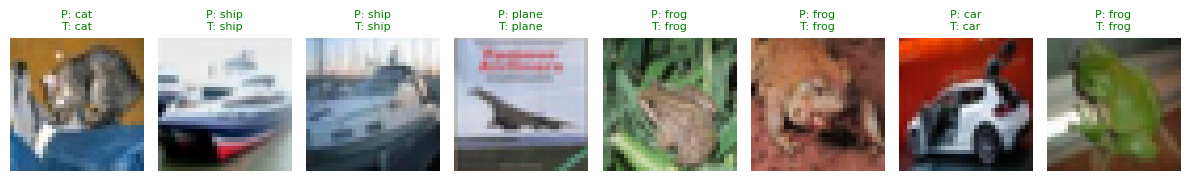

In [23]:
# Base model
visualize_model_predictions(base_model, val_loader, device=gpu, num_images=8)

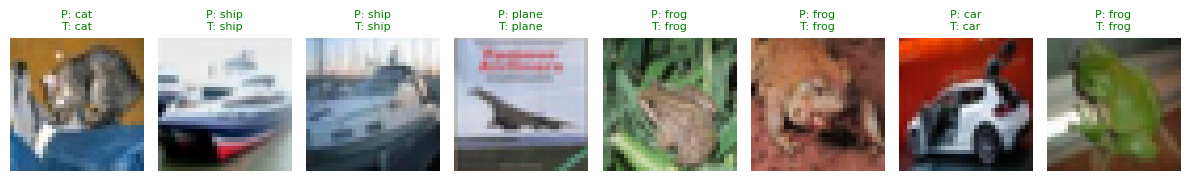

In [24]:
# Pruned models
#visualize_model_predictions(pruned_model_50, val_loader, device=gpu, num_images=8)
#visualize_model_predictions(pruned_model_70, val_loader, device=gpu, num_images=8)
visualize_model_predictions(pruned_kd_model_70, val_loader, device=gpu, num_images=8)

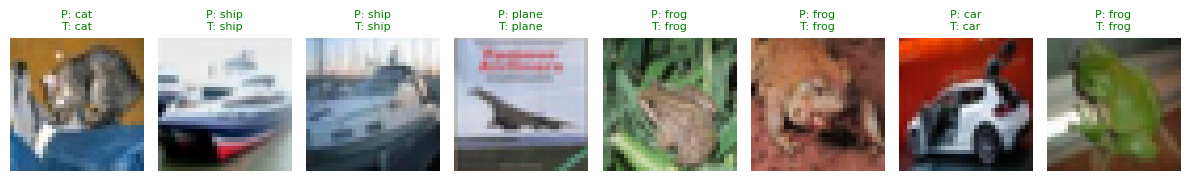

In [25]:
# Quantized models
#visualize_model_predictions(base_quantized_model_30, val_loader, device="cpu", num_images=8)
visualize_model_predictions(pruned_kd_quantized_model_30, val_loader, device="cpu", num_images=8)